<a href="https://colab.research.google.com/github/YashAw12/Neural-Style-Transfer/blob/main/Neural_style_transfer_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
from keras.applications.vgg16 import VGG16
%matplotlib inline

In [ ]:


# Set a random seed for reproducibility
tf.random.set_seed(272)

# Initialize PrettyPrinter for structured output
pp = PrettyPrinter(indent=4)

# Define image size
img_size = 224

# Load the VGG16 model pre-trained on ImageNet dataset
vgg_model = VGG16(weights='imagenet')

# Print the model summary
print(vgg_model.summary())

# Set the model's trainable attribute to False to freeze the layers
vgg_model.trainable = False

# Use PrettyPrinter to display the model configuration
pp.pprint(vgg_model)


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Iterate over the layers and print their names
for layer in vgg_model.layers:
    print(layer.name)

input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
flatten
fc1
fc2
predictions


In [ ]:
block5_conv3_output = vgg_model.get_layer('block5_conv3').output
print(block5_conv3_output)

KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 512), dtype=tf.float32, name=None), name='block5_conv3/Relu:0', description="created by layer 'block5_conv3'")


In [ ]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [ ]:
def compute_content_cost(content_output, generated_output):
    # Extract the content activations from the last layer
    a_C = content_output[-1]
    a_G = generated_output[-1]

    # Get the dimensions of the generated image activations
    _, n_H, n_W, n_C = a_G.get_shape().as_list()

    # Reshape the activations to (batch_size, n_H * n_W, n_C)
    a_C_unrolled = tf.reshape(a_C, shape=[-1, n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[-1, n_H * n_W, n_C])

    # Compute the mean squared difference between a_C_unrolled and a_G_unrolled
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled))) / (4 * n_H * n_W * n_C)

    return J_content


In [ ]:
def gram_matrix(A):

  GA = tf.matmul(A,tf.transpose(A))



  return GA



In [ ]:
def compute_layer_style_cost(a_S, a_G):
    # Get dimensions from a_G tensor
    _, n_H, n_W, n_C = a_G.get_shape().as_list()

    # Reshape a_S and a_G to have shape (n_H * n_W, n_C)
    a_S = tf.reshape(a_S, [n_H * n_W, n_C])
    a_G = tf.reshape(a_G, [n_H * n_W, n_C])

    # Transpose a_S and a_G to compute the Gram matrix correctly
    a_S = tf.transpose(a_S)
    a_G = tf.transpose(a_G)

    # Compute Gram matrices for style and generated image
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Compute the mean squared difference between GS and GG
    J_style_layer = tf.reduce_sum(tf.square(GS - GG)) / (4.0 * (n_C ** 2) * (n_H * n_W) ** 2)

    return J_style_layer


In [ ]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS):
    J_style = 0

    # Extract the style activations and generated activations up to the last layer
    a_S = style_image_output[:-1]
    a_G = generated_image_output[:-1]

    # Iterate over each specified layer
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):
        # Compute the style cost for each layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Accumulate the weighted style cost
        J_style += weight[1] * J_style_layer

    return J_style


In [ ]:
@tf.function()
def total_cost(J_content, J_style, alpha=10, beta=40):
    """
    Computes the total loss function for neural style transfer.

    Arguments:
    J_content -- content cost, scalar value
    J_style -- style cost, scalar value
    alpha -- weight for the content cost
    beta -- weight for the style cost

    Returns:
    J -- total cost, scalar value
    """

    # Compute the total cost using the formula
    J = alpha * J_content + beta * J_style

    return J


(1, 224, 224, 3)


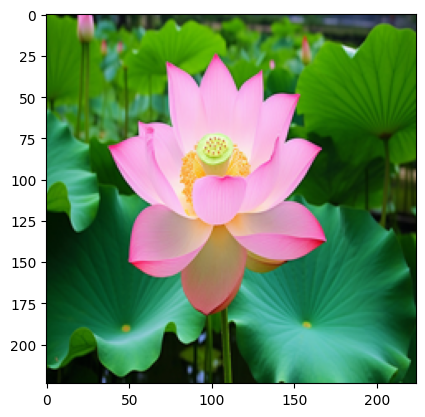

In [ ]:
# Load the content image and resize it
content_image = np.array(Image.open("content2.jpg").resize((img_size, img_size)))

# Convert to TensorFlow tensor and add batch dimension
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

# Print the shape of the tensor
print(content_image.shape)  # Should print (1, img_size, img_size, 3)
# Display the content image
imshow(content_image[0])
plt.show()

(1, 224, 224, 3)


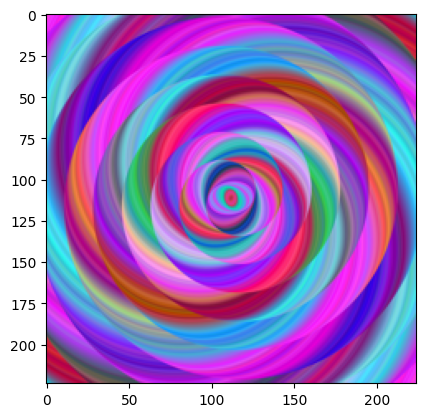

In [ ]:
style_image =  np.array(Image.open("pattern2.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

In [ ]:


# Initialize the generated image as a variable
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

# Add random noise to the generated image
noise = tf.random.uniform(tf.shape(generated_image), -0.5, 0.5)
generated_image = tf.add(generated_image, noise)

# Clip the pixel values to be within the [0, 1] range
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)




# Display the generated image
print(generated_image.shape)  # Should print (1, img_size, img_size, 3)
imshow(generated_image.numpy()[0])
plt.show()

In [ ]:


def get_layer_outputs(vgg, layer_names):
    """
    Creates a model that returns a list of intermediate output values from VGG network.

    Arguments:
    vgg -- pre-trained VGG model
    layer_names -- list of tuples, each containing a layer name and index in VGG

    Returns:
    model -- Keras Model instance that outputs activations of specified layers
    """

    # Extract the outputs of the specified layers from the VGG model
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    # Create a new model that outputs the activations of specified layers
    model = tf.keras.Model(inputs=[vgg.input], outputs=outputs)

    # Print model summary for verification
    print(model.summary())

    return model


In [ ]:
# Assuming STYLE_LAYERS is defined as [('block1_conv1', 1), ('block2_conv2', 1), ...]
content_layer = [('block5_conv3', 1)]

# Combine style and content layers
combined_layers = STYLE_LAYERS + content_layer

In [ ]:
content_target = vgg_model_outputs(content_image)
style_targets = vgg_model_outputs(style_image)

In [ ]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

In [ ]:
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [ ]:
def clip_0_1(image):
    """
    Clips pixel values of the image tensor to be within the range [0, 1].

    Arguments:
    image -- input image tensor

    Returns:
    clipped_image -- image tensor with pixel values clipped to [0, 1]
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


def tensor_to_image(tensor):
    """
    Converts a TensorFlow tensor to a PIL Image.

    Arguments:
    tensor -- input TensorFlow tensor (typically representing an image)

    Returns:
    PIL Image
    """
    tensor = tensor * 255  # Scale tensor values to [0, 255]
    tensor = np.array(tensor, dtype=np.uint8)  # Convert tensor to numpy array of uint8 type

    # If tensor has more than 3 dimensions (e.g., batch dimension), squeeze it
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1  # Ensure batch dimension is 1
        tensor = tensor[0]  # Remove batch dimension

    # Create PIL Image from numpy array
    return Image.fromarray(tensor)


In [ ]:
total_loss = np.array([], dtype=np.float64)
content_loss= np.array([], dtype=np.float64)
style_loss = np.array([], dtype=np.float64)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    """
    Executes a single training step for neural style transfer.

    Arguments:
    generated_image -- TensorFlow Variable representing the generated image

    Returns:
    J -- total loss
    J_content -- content loss
    J_style -- style loss
    """

    with tf.GradientTape() as tape:
        # Forward pass through the model to compute activations
        a_G = vgg_model_outputs(generated_image)

        # Compute style loss
        J_style = compute_style_cost(a_S, a_G, STYLE_LAYERS=STYLE_LAYERS)

        # Compute content loss
        J_content = compute_content_cost(a_C, a_G)

        # Compute total loss
        J = total_cost(J_content, J_style, alpha=10, beta=30)

    # Compute gradients of total loss with respect to generated_image
    grad = tape.gradient(J, generated_image)

    # Apply gradients using the Adam optimizer
    optimizer.apply_gradients([(grad, generated_image)])

    # Clip generated_image to ensure pixel values are in [0, 1] range
    generated_image.assign(clip_0_1(generated_image))

    return J, J_content, J_style


Epoch 0 
8.669748306274414 ,0.020873388275504112,0.2820338308811188


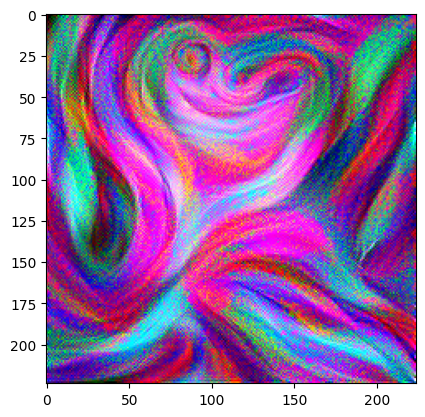

In [ ]:
generated_image = tf.Variable(generated_image)
epochs = 1001
for i in range(epochs):
    J, J_content, J_style=train_step(generated_image)
    total_loss=np.append(total_loss,J)
    content_loss=np.append(content_loss,J_content)
    style_loss=np.append(style_loss,J_style)
    if i % 500 == 0:
        print(f"Epoch {i} ")
        print(f"{J} ,{J_content},{J_style}")
    if i % 1000 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)

#
        plt.show()

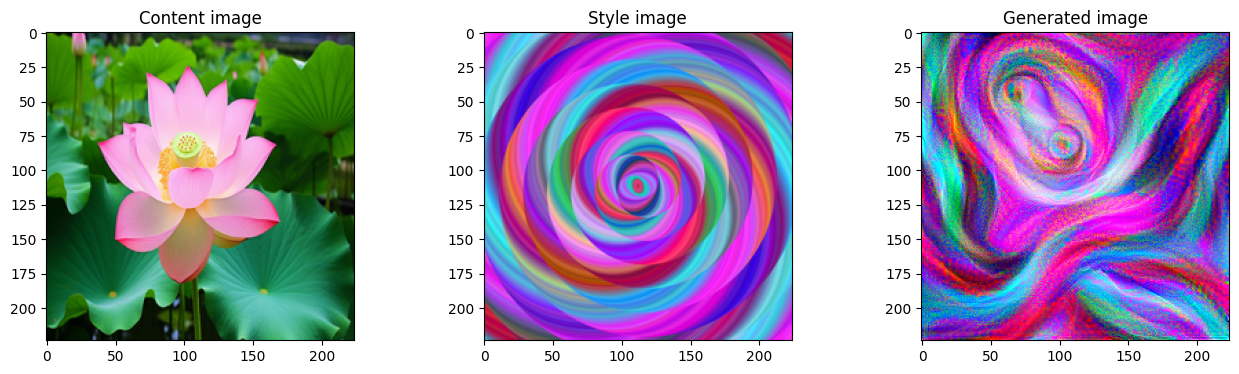

In [ ]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()

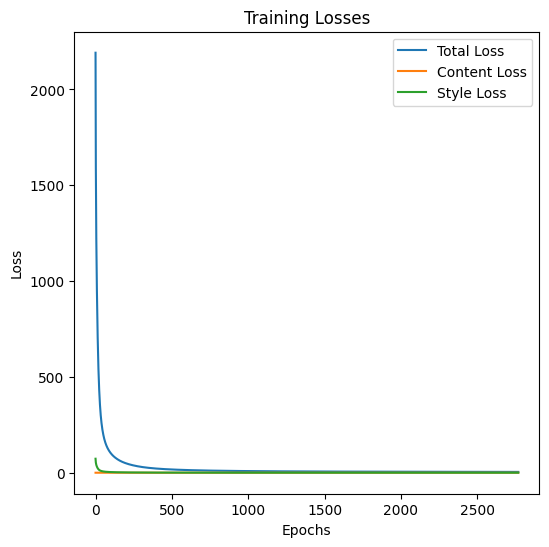

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(total_loss, label='Total Loss')
plt.plot(content_loss, label='Content Loss')
plt.plot(style_loss, label='Style Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()